In [28]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version: ", tf.__version__) 

Tensorflow version:  2.16.1


Exploring Dataset


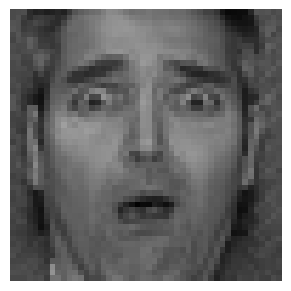

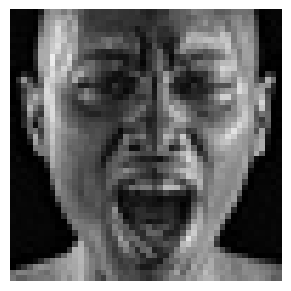

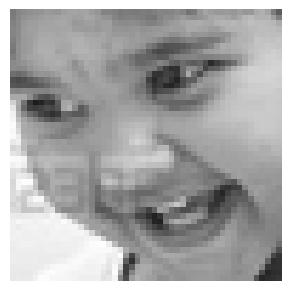

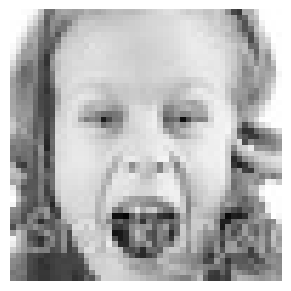

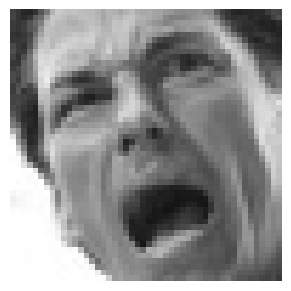

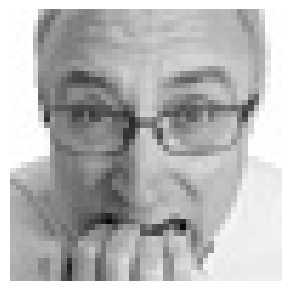

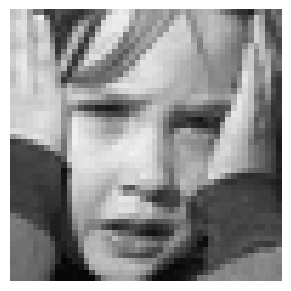

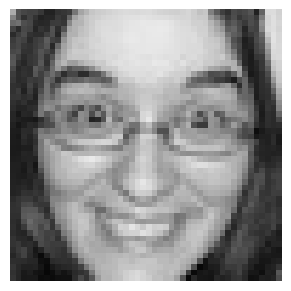

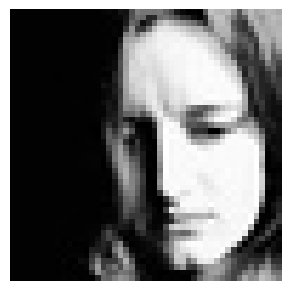

In [29]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')

In [30]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size ,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)


datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size ,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Define a Model

In [31]:
def Convolution(input_tensor, filters, kernel_size):
    x= Conv2D(filters, kernel_size = kernel_size, padding= "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size= (2,2))(x)
    return x

In [32]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [33]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)
    
    output = Dense(7, activation= "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model    
    

In [34]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

Initalizing The Model


In [35]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint(".weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]


**Training The Model**

In [36]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)


Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.3314 - loss: 1.7914
Epoch 1: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 254s 561ms/step - accuracy: 0.3315 - loss: 1.7910 - val_accuracy: 0.3105 - val_loss: 1.9005
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:15 437ms/step - accuracy: 0.4688 - loss: 1.3703
Epoch 2: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.4688 - loss: 1.3703 - val_accuracy: 0.1000 - val_loss: 2.3161
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.4945 - loss: 1.3459
Epoch 3: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 274s 610ms/step - accuracy: 0.4945 - loss: 1.3459 - val_accuracy: 0.4159 - val_loss: 1.4898
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:14 435ms/step - accuracy: 0.5312 - loss: 1.3444
Epoch 4: saving model to .weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.5312 - loss: 1.3444 - val_accuracy: 0.5000 - val_loss: 1.7515
Epoch 5/15
448/4

 Model Evaluation

In [38]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.4309 - loss: 1.8849


[1.8808939456939697, 0.4324324429035187]

Plotting Loss

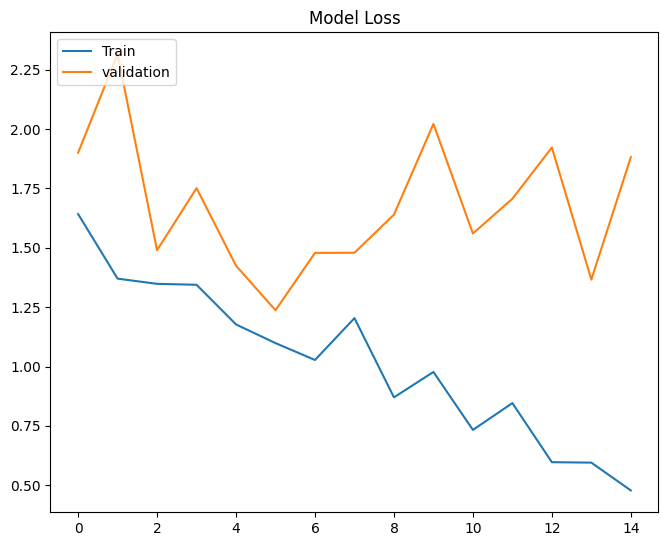

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

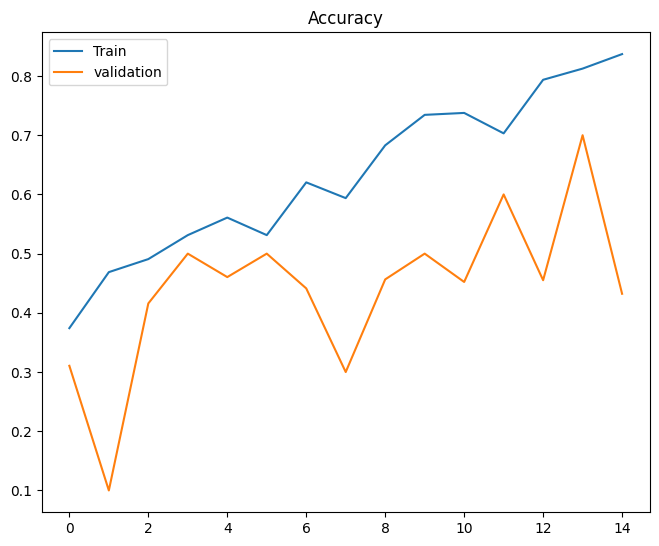

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train', 'validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

Saving Model

In [41]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)